# Проект: классификация

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

  Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

  Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

  Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

 *Целевая переменная deposit,* которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [87]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [88]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()
# ваш код

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [89]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [90]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.describe(include=object)
# ваш код

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


In [91]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [92]:
df['balance'].dtype

dtype('O')

### Задание 3

In [93]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: x if [x]==[np.nan] else float((x.replace(' ', '')).replace(',', '.').replace('$', '')))
round(df['balance'].mean(),2)

1529.13

In [94]:
round(df['balance'].mean(),2)

1529.13

### Задание 4

In [95]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'].fillna(df['balance'].median(),inplace = True)
# ваш код

In [96]:
round(df['balance'].mean(),2)

1526.94

### Задание 5

In [97]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)
# ваш код

In [98]:
round(df['balance'].loc[(df['job']==df['job'].mode()[0]) & (df['education']==df['education'].mode()[0])].mean(),3)

1598.883

### Задание 6

In [99]:
# удалите все выбросы для признака balance методом межквартильного размаха (Тьюки)
quantile_1, quantile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75) # вычислить 25-ый и 75-ый квантили (первый и третий квартили) 
iqr = quantile_3 - quantile_1 # вычислить межквартильное расстояние
# вычислить верхнюю и нижнюю границы Тьюки
lower_bound = quantile_1 - iqr * 1.5
upper_bound = quantile_3 + iqr * 1.5
outliers = df[(df['balance'] <= lower_bound) | (df['balance'] >= upper_bound)]
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)].reset_index().drop('index', axis=1)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df .shape[0]}')

Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


In [100]:
lower_bound

-2241.0

## Часть 2:  Разведывательный анализ

### Задание 1

In [101]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
df['deposit'].value_counts()
# ваш код

no     5424
yes    4681
Name: deposit, dtype: int64

no     5424
yes    4681
Name: deposit, dtype: int64

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

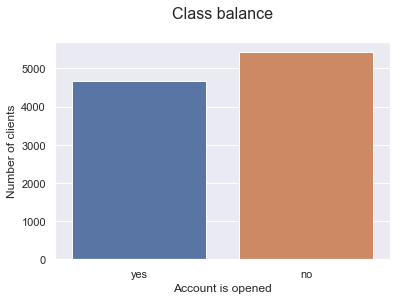

In [102]:
display(df['deposit'].value_counts())
display(df['deposit'].value_counts(normalize=True))

ax = sns.countplot(df['deposit'])
ax.set(xlabel='Account is opened', ylabel='Number of clients')
ax.set_title('Class balance\n',fontsize=16);

### Задания 2 и 3

In [103]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()
#ваш код

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


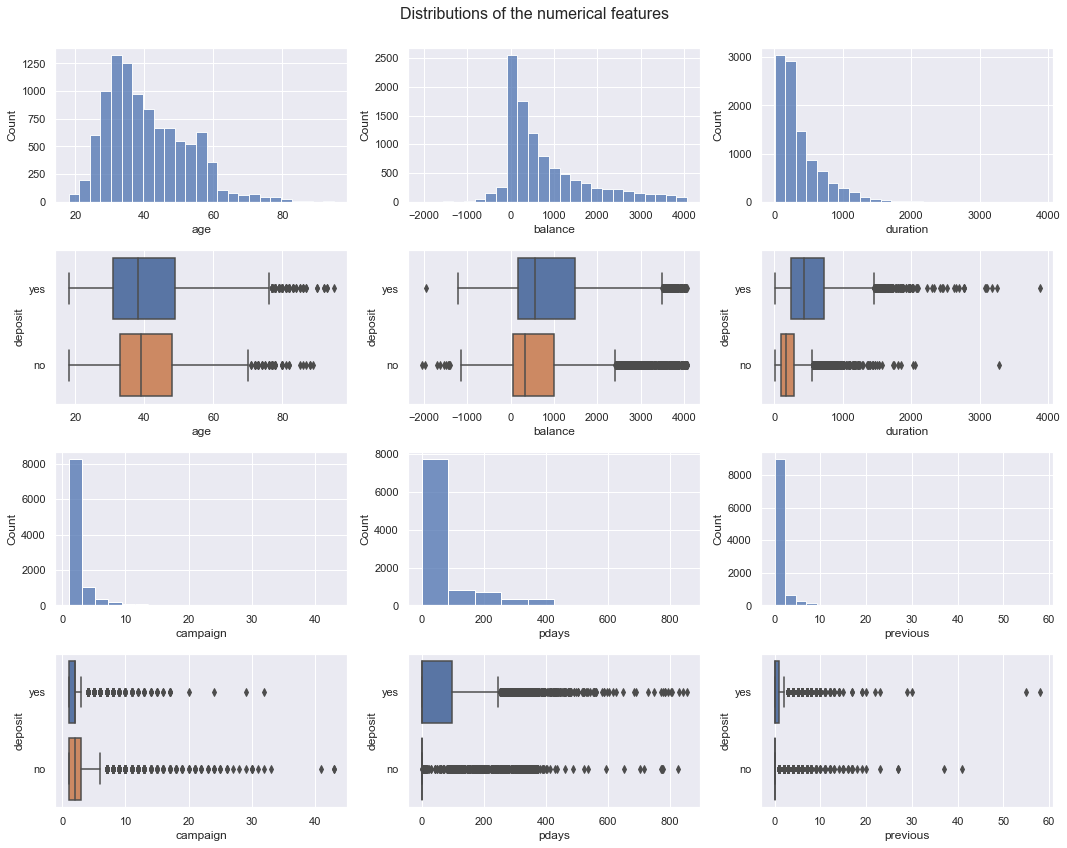

In [104]:
fig, ax = plt.subplots(4,3, figsize=(15,12))
sns.histplot(df['age'], bins=25, ax=ax[0,0])       # Возраст
sns.histplot(df['balance'], bins=25, ax=ax[0,1])  # Баланс
sns.histplot(df['duration'], bins=25, ax=ax[0,2])  # Продолжительность контакта
sns.boxplot(data=df, x='age', y='deposit', ax=ax[1,0]) 
sns.boxplot(data=df, x='balance', y='deposit', ax=ax[1,1]) 
sns.boxplot(data=df, x='duration', y='deposit', ax=ax[1,2]) 
sns.histplot(df['campaign'], bins=20, ax=ax[2,0])   # Количество контактов
sns.histplot(df['pdays'], bins=10, ax=ax[2,1])      # Количество дней после предыдущей кампании
sns.histplot(df['previous'], bins=25, ax=ax[2,2])   # Количество предыдущих контактов
sns.boxplot(data=df, x='campaign', y='deposit', ax=ax[3,0]) 
sns.boxplot(data=df, x='pdays', y='deposit', ax=ax[3,1]) 
sns.boxplot(data=df, x='previous', y='deposit', ax=ax[3,2]) 
plt.suptitle('Distributions of the numerical features\n', fontsize=16)
plt.tight_layout()

#### <center> **КОММЕНТАРИИ**
- 1. Пик возраста(age) клинетов приходится на 30-35 лет. После 60 лет кол-во клиентов резко уменьшается.
- 2. Основное кол-во баланса(balance) приходится на ноль, стоит отметить отрицательный баланс( стоит подумать над тем, чтоб убрать выбросы отрицательной стороны) у малой части клиентов, в основном распределение логнормальное.
- 3. Продолжительность контакта (duration). Средняя продолжительность контакта около 5 мин. Распределение логнормальное. Возможно наличие выбросов - контакт более 30 мин.
- 4. Количество контактов (campaign). Логнормальное. Выбросы - число контактов более 15.
- 5. Количество дней с момента предыдущей кампании (pdays). Логнормальное. Выбросы - более 500 дней.
- 6. Количество предыдущих контактов (previous). Логнормальное. Выбросы аналогичны признаку campaign - более 15.

Визуально значимые отличия в распределениях по отношению к целевому признаку - открытию депозита (deposit) - наблюдаются у нескольких признаков (см. диаграммы размаха). На вероятное открытие депозита указывает продолжительность контакта - чем он дольше, тем выше шансы положительного результата. Наоборот, большее количество контактов с клиентом говорит о меньших шансах, т.е. попытки контактировать с клиентом более нескольких раз не имеют особого смысла, результат либо достигается при первых контактах, либо не достигается вообще. Более вероятно открытие депозита у клиентов с большей суммой на счете. Распределение признака pdays говорит, что чем раньше возникает контакт после проекта, тем больше шанс положтиетльного исходаб и previous говорит о том, что наличие предыдущих контактов также увелчивает шанс, не открывших депозит, относятся к новым (pdays=-1, previous=0). Распределение по возрасту для клиентов, не открывших депозит, имеет меньшую дисперсию по сравнению с открывшими, но медианные значения почти не отличаются.

### Задания 4 и 5

In [105]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include=object)

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


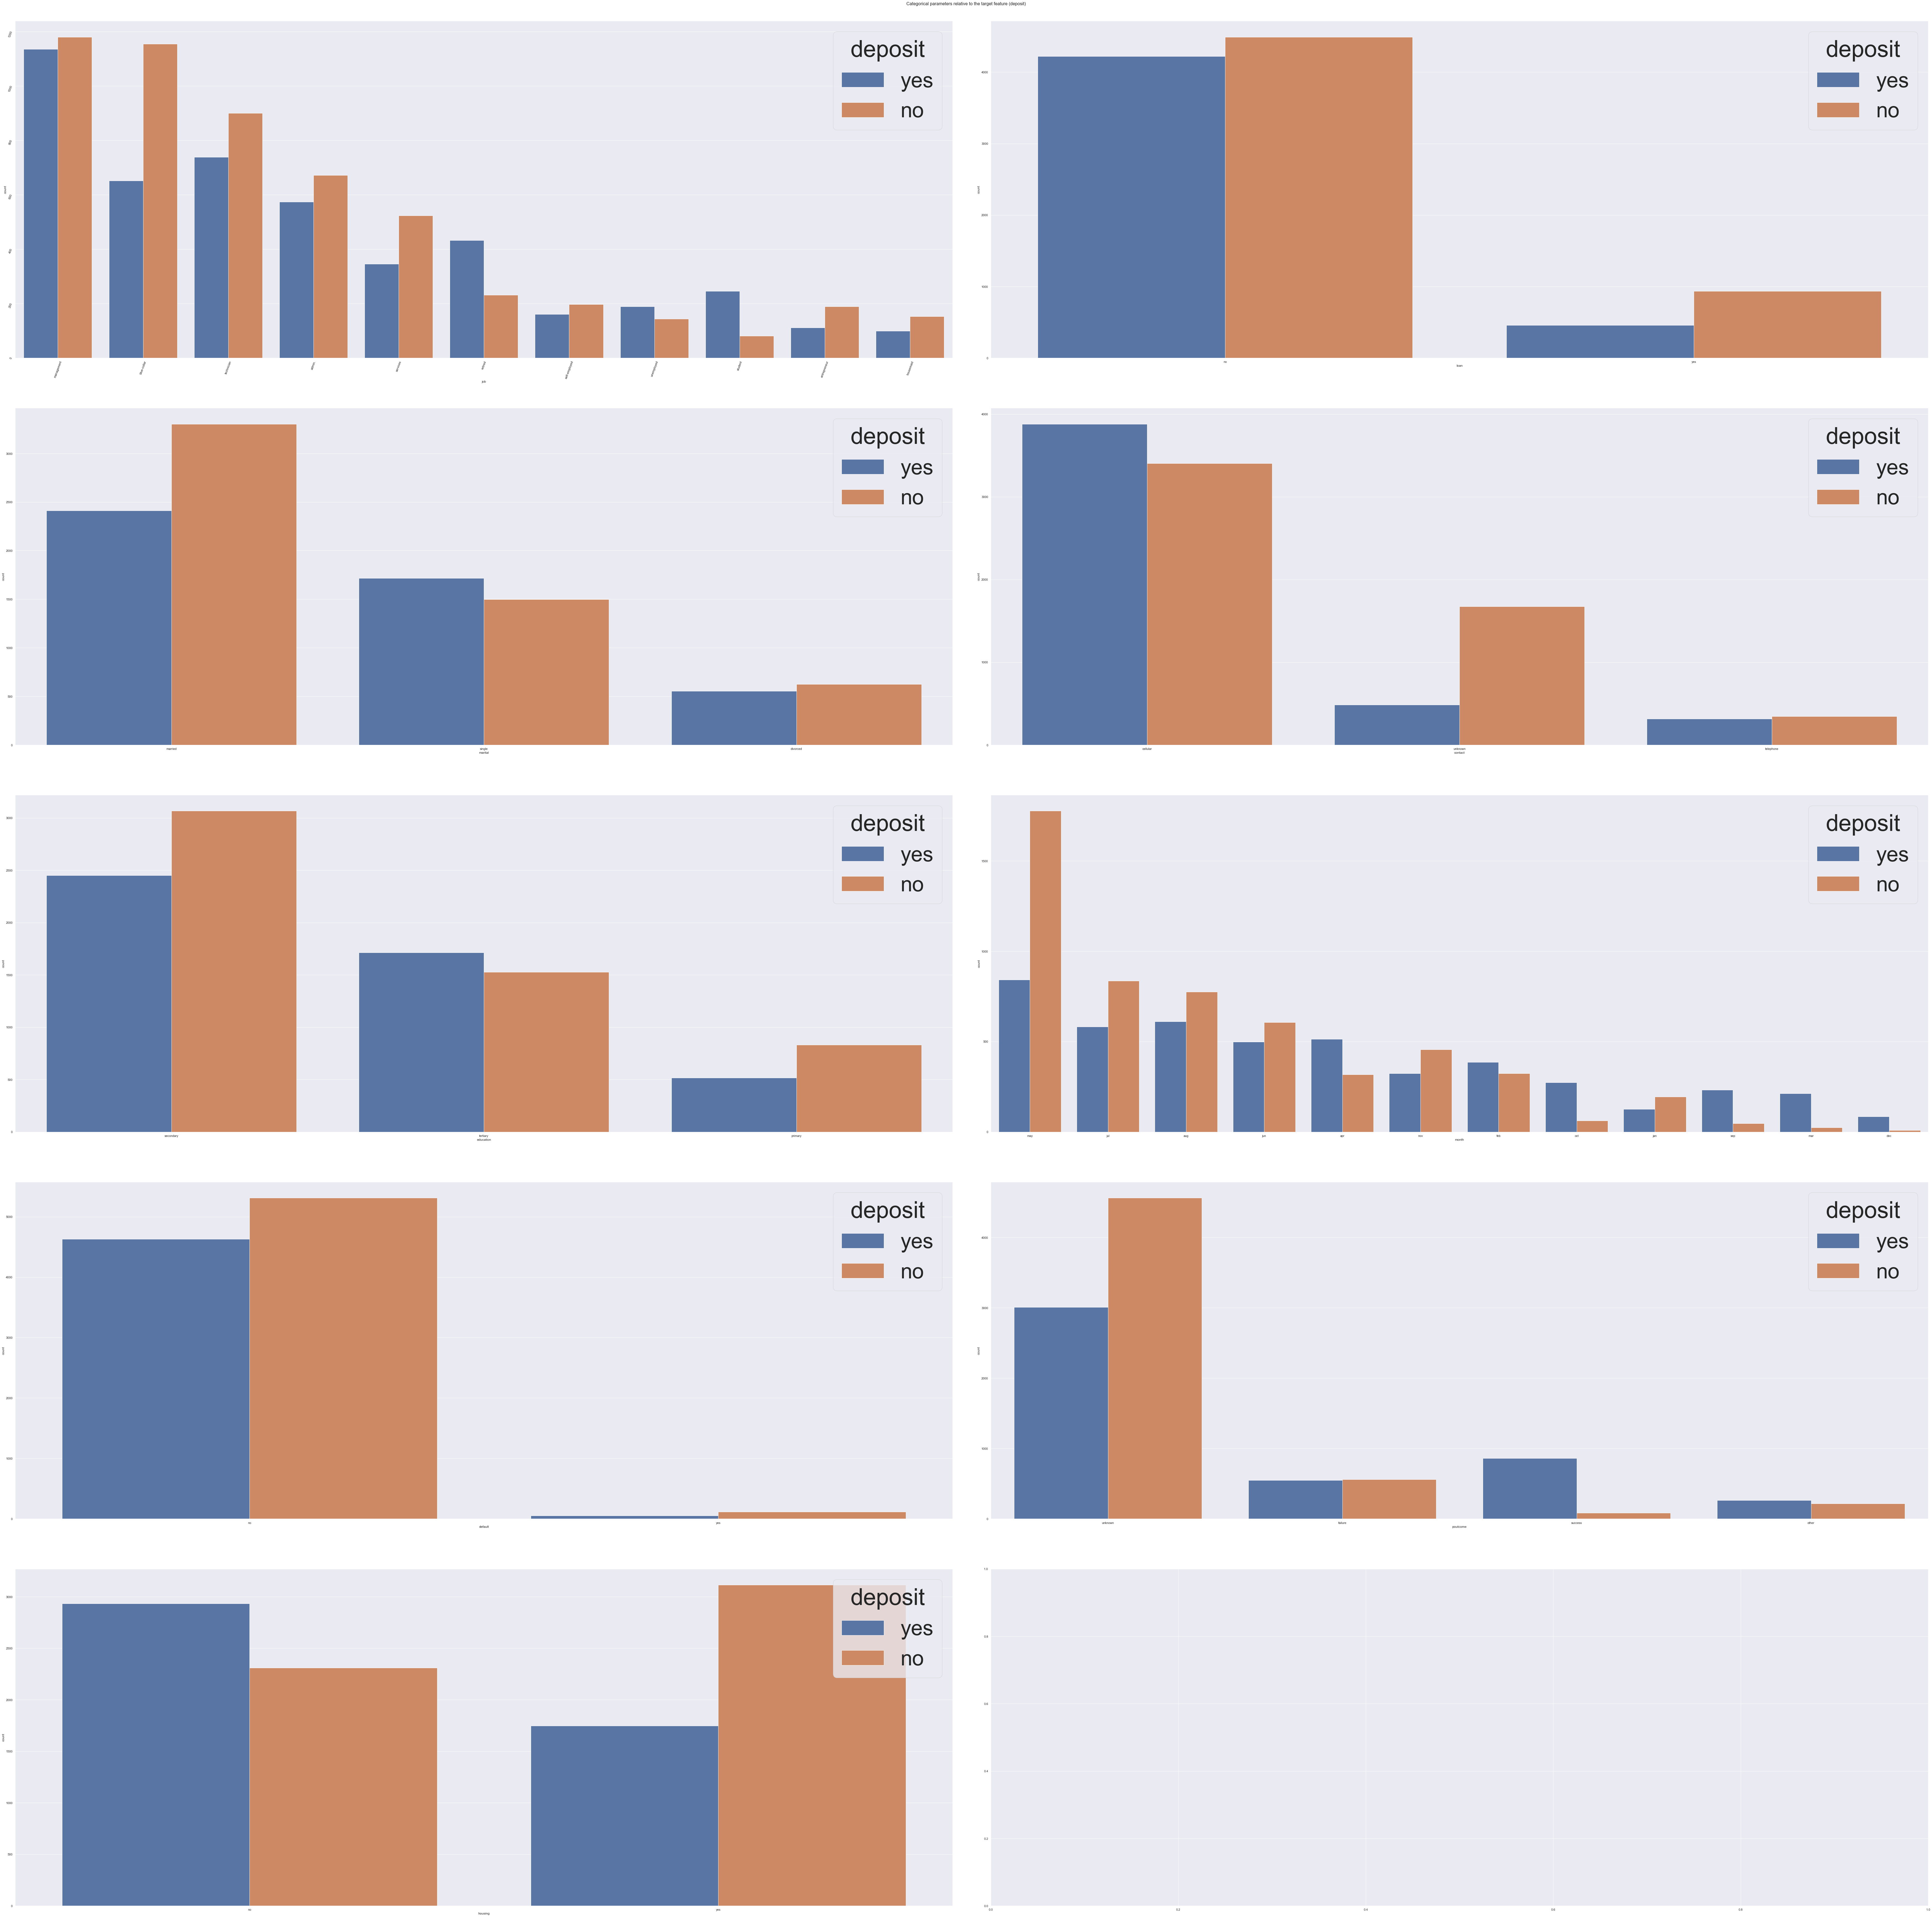

In [106]:

#ваш код
#постройте визуализации, иллюстрирующие результаты
display(df.describe(include='object'))

fig, ax = plt.subplots(5,2, figsize=(100,100))
sns.set (font_scale= 7 )
# Сфера занятости
sns.countplot(
    data=df, x='job', hue='deposit', 
    order=df['job'].value_counts().index, ax=ax[0,0])

# Семейное положение
sns.countplot(
    data=df, x='marital', hue='deposit',
    order=df['marital'].value_counts().index, ax=ax[1,0])

# Уровень образования
sns.countplot(
    data=df, x='education', hue='deposit',
    order=df['education'].value_counts().index, ax=ax[2,0])

# Наличие просроченного кредита
sns.countplot(
    data=df, x='default', hue='deposit',
    order=df['default'].value_counts().index, ax=ax[3,0])

# Наличие ипотеки
sns.countplot(
    data=df, x='housing', hue='deposit',
    order=df['housing'].value_counts().index, ax=ax[4,0])

# Наличие потребительского кредита
sns.countplot(
    data=df, x='loan', hue='deposit',
    order=df['loan'].value_counts().index, ax=ax[0,1])

# Тип контакта с клиентом
sns.countplot(
    data=df, x='contact', hue='deposit', 
    order=df['contact'].value_counts().index, ax=ax[1,1])

# Месяц последнего контакта с клиентом
sns.countplot(
    data=df, x='month', hue='deposit',
    order=df['month'].value_counts().index, ax=ax[2,1])

# Результат предыдущей маркетинговой кампании
sns.countplot(
    data=df, x='poutcome', hue='deposit',
    order=df['poutcome'].value_counts().index, ax=ax[3,1])
ax[0,0].tick_params(labelrotation=70)
plt.suptitle(
    'Categorical parameters relative to the target feature (deposit)\n',
    fontsize=16)
plt.tight_layout()

На рисунке видим соотношения различных категорий клиентов в разрезе достижения целевого признака - открытия депозита (deposit). Можно сказать, что аиболее склонны к открытию депозита следующие категории клиентов:

- пенсионеры и студенты (при небольшом относительном количестве и тех и других);
- клиенты, по которым был достигнут успех в предыдущей маркетинговой кампании - подавляющее большинство дают положительный результат и в текущей кампании;
- неженатые/незамужние клиенты, а также клиенты, не имеющие ипотеки (и те, и другие - в меньшей степени, однако в этих категориях число клиентов, открывших депозит, превышает число отрицательных результатов, что довольно нетипично для выборки в целом);
- клиенты, с которыми связывались по мобильному телефону - та же картина.
Наиболее неудачные результаты по привлечению к открытию депозита:

- "синие воротнички";
- клиенты с потребительскими кредитами

По какой-то причине наблюдаются значительные различия в успешности маркетинговой кампании по месяцам: исключительно успешные результаты в марте, апреле, сентябре, октябре и декабре, но существенный провал в мае. Данное обстоятельство требует дополнительного изучения в контексте построения модели машинного обучения - результаты могут быть связаны с конкретными "локальными" обстоятельствами маркетинговой кампании и не отражать общей тенденции (зависимости от времени года). Включение такой локальной зависимости в модель приведет к успешному предсказанию текущей ситуации, в том числе на тестовой выборке, однако нет гарантии, что новые данные будут соответствовать модели.

### Задание 6

In [107]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts().unstack()
# ваш код

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 7

In [108]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby('month')['deposit'].value_counts(normalize=True).unstack().sort_values('no')
# ваш код

deposit,no,yes
month,,
dec,0.096774,0.903226
mar,0.101266,0.898734
sep,0.165468,0.834532
oct,0.185075,0.814925
apr,0.381928,0.618072
feb,0.455571,0.544429
jun,0.548913,0.451087
aug,0.559567,0.440433
nov,0.584615,0.415385


### Задание 8

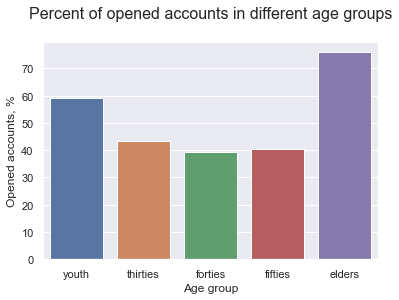

In [109]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(x):
    if x < 30:
        return 'youth'
    elif 30 <= x < 40:
        return 'thirties'
    elif 40 <= x < 50:
        return 'forties'
    elif 50 <= x < 60:
        return 'fifties' 
    else:
        return 'elders'   


df['age_group'] = df['age'].apply(age_group)
sns.set (font_scale= 1 )
piv_tab = (df.groupby('age_group')['deposit'].value_counts(normalize=True) \
    * 100).unstack().reset_index() # процент отказов/согласия по группам
ax = sns.barplot(
    data=piv_tab, x='age_group', y='yes', 
    order=['youth', 'thirties', 'forties', 'fifties', 'elders'])
ax.set(ylabel='Opened accounts, %', xlabel='Age group')
ax.set_title('Percent of opened accounts in different age groups\n', 
             fontsize=16);

### Задания 9 и 10

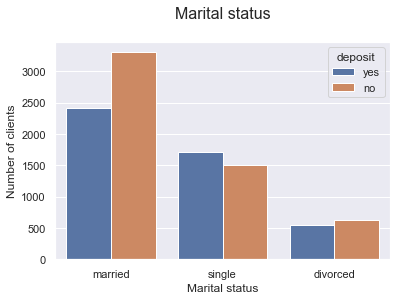

In [110]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
#ваш код
#постройте визуализации, иллюстрирующие результаты
sns.set (font_scale= 1 )
ax = sns.countplot(data=df, x='marital', hue='deposit')
ax.set(xlabel='Marital status', ylabel='Number of clients')
ax.set_title('Marital status\n', fontsize=16);

Наиболее многочисленная группа - семейные, наиболее малочисленная - разведенные. Неженатые/незамужние более склонны к открытию депозита, чем семейные.


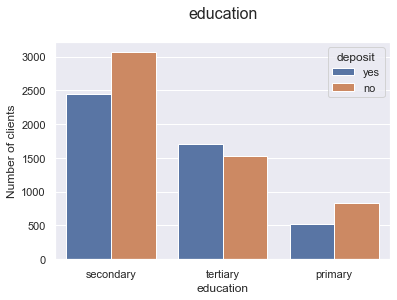

In [111]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.set (font_scale= 1 )
ax = sns.countplot(data=df, x='education', hue='deposit')
ax.set(xlabel='education', ylabel='Number of clients')
ax.set_title('education\n', fontsize=16);

У большинства клиентов среднее образование. Более склонны к открытию депозита клиенты с высшим образованием.

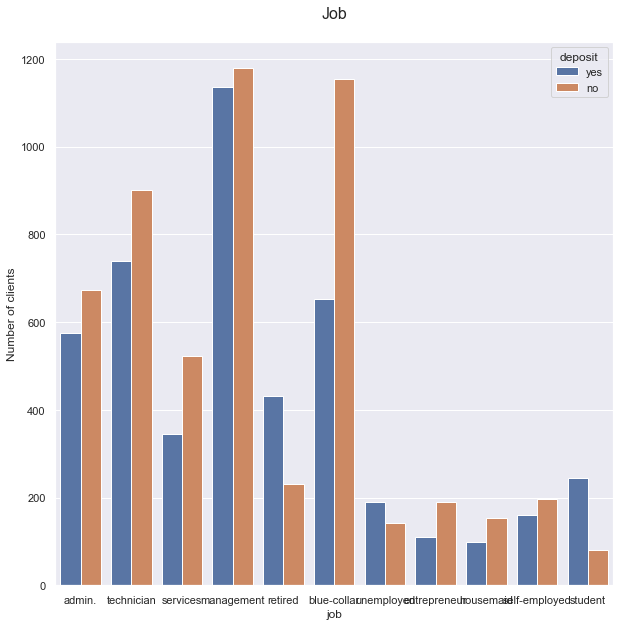

In [112]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.set (font_scale= 1 )
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.countplot(data=df, x='job', hue='deposit')
ax.set(xlabel='job', ylabel='Number of clients')
ax.set_title('Job\n', fontsize=16);


Выделяется малый процент открытия депозитов у "синих воротничков" и большой - у пенсионеров и студентов. Важно отметить, что при этом "синие воротнички" составляют вторую по численности категорию клиентов (стоить подумать о способах привлечения этой категории).

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


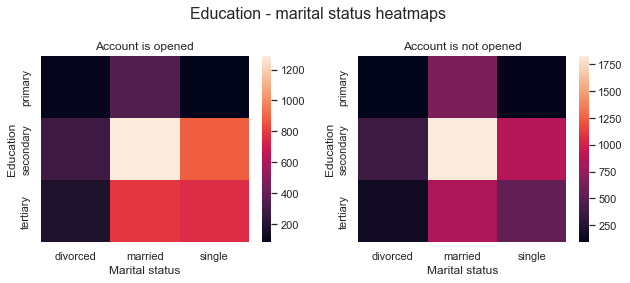

In [113]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
success = df[df['deposit']=='yes']
fail = df[df['deposit']=='no']
success_pivot = success.groupby(
    ['education', 'marital'])['marital'].count().unstack()
## or:
#success_pivot = pd.pivot_table(success,     
#    index='education', columns='marital', values='age', aggfunc='count')  
fail_pivot = fail.groupby(
    ['education', 'marital'])['marital'].count().unstack()

display(success_pivot, fail_pivot)

fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(success_pivot, ax=ax[0])
sns.heatmap(fail_pivot, ax=ax[1])
ax[0].set_title('Account is opened')
ax[1].set_title('Account is not opened')
ax[0].set(xlabel='Marital status', ylabel='Education')
ax[1].set(xlabel='Marital status', ylabel='Education')
plt.suptitle('Education - marital status heatmaps', fontsize=16)
plt.tight_layout()

В обеих категориях (открывшие и неоткрывшие депозит) преобладают семейные клиенты со средним образованием.

## Часть 3: преобразование данных

### Задание 1

In [114]:
# преобразуйте уровни образования
label_enc = preprocessing.LabelEncoder()
df['education'] = label_enc.fit_transform(df['education'])
df['education'].sum()

11995

### Задания 2 и 3

In [115]:
# преобразуйте бинарные переменные в представление из нулей и единиц
def age_group(x):
    if x < 30:
        return '1'
    elif 30 <= x < 40:
        return '2'
    elif 40 <= x < 50:
        return '3'
    elif 50 <= x < 60:
        return '4' 
    else:
        return '5'

df['age_group'] = df['age'].apply(age_group)

In [116]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [117]:
round(df['deposit'].std(),3)

0.499

In [118]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [119]:
df['loan'].mean() + df['housing'].mean() + df['default'].mean()

0.6354280059376547

### Задание 4

In [120]:
# создайте дамми-переменные
dummies = pd.get_dummies(df[[
    'job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df, dummies], axis=1)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int32  
 4   default            10105 non-null  int64  
 5   balance            10105 non-null  float64
 6   housing            10105 non-null  int64  
 7   loan               10105 non-null  int64  
 8   contact            10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  deposit            101

In [122]:
# Удаляем преобразованные признаки типа object

obj_cols = df.select_dtypes('object').columns
df.drop(columns=obj_cols, inplace=True)

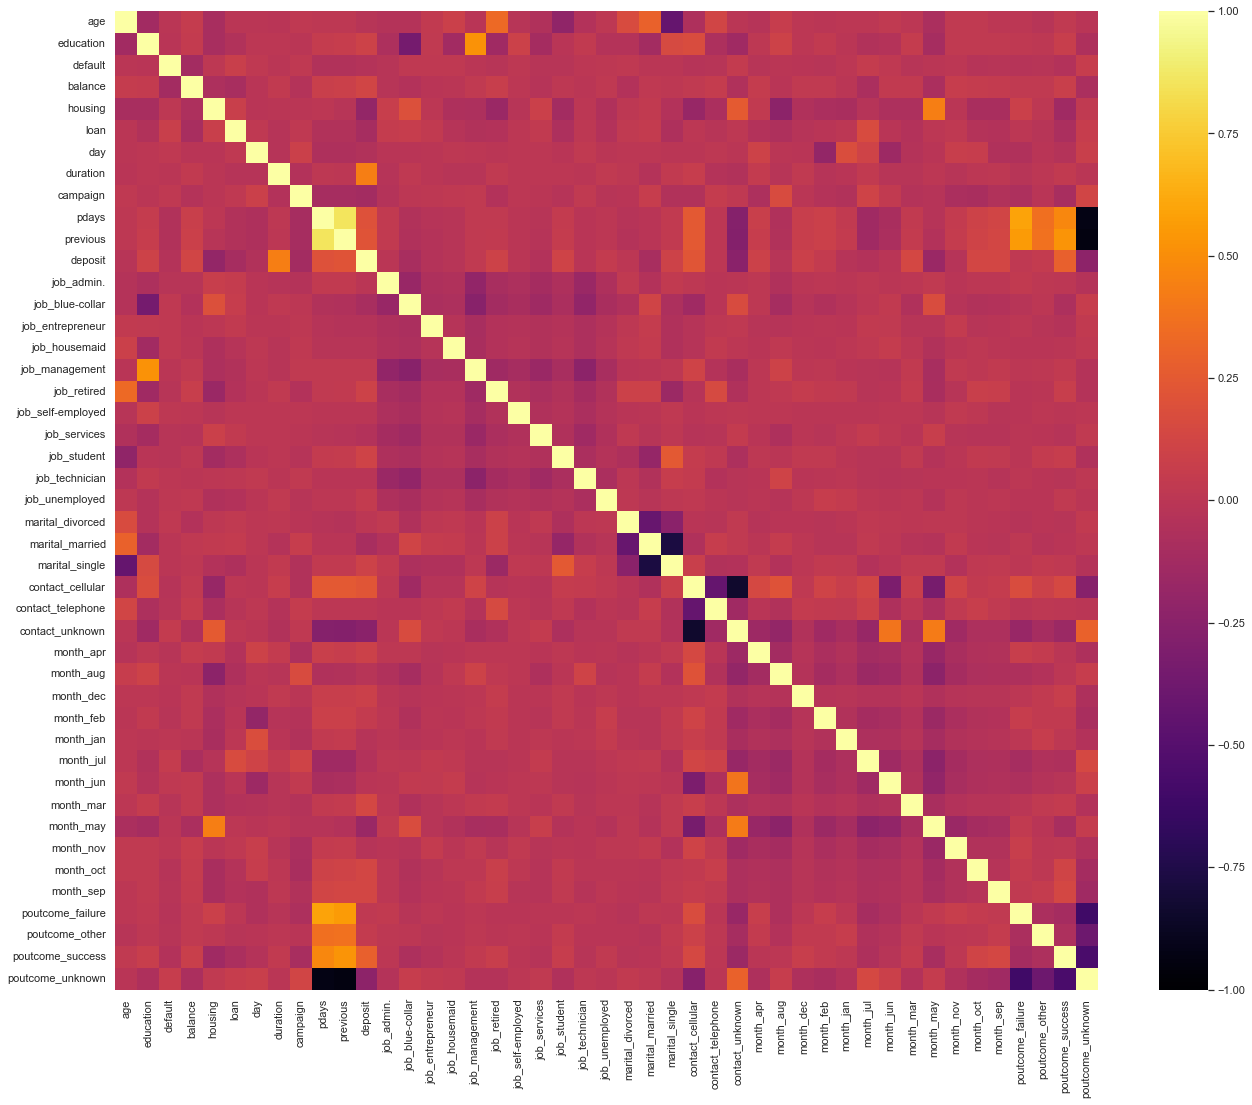

In [123]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

# Корреляционная матрица 
# Используем корреляцию Кендала - распределение признака может быть 
# не нормальным, связь признаков не обязательно является монотонной функцией
corr_matrix = df.corr(method='kendall')
sns.set (font_scale= 1 )
# Тепловая карта
fig = plt.figure(figsize=(22,18))
sns.heatmap(corr_matrix,  vmin=-1, vmax=1,fmt='.2f',annot=False, center=0,cmap='inferno');


In [124]:
# Вычисляем мультиколлинеарные признаки, порог 0.9 
# (порог в соответствии с требованиями задания).
# Использую заготовленную функцию определения мультиколлинеарных признаков

def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


get_correlated(corr_matrix, thres=0.9)

previous -- poutcome_unknown   -0.938271
pdays -- poutcome_unknown      -0.925560
dtype: float64

Большой коэффициент корреляции между previous, poutcome_unknown и pdays обусловлен сильной несбалансированностью каждого из признаков - большинство экземпляров показывают одно и то же значение признака:

In [125]:
display(df['poutcome_unknown'].value_counts())
display(df['previous'].value_counts()[:3])
display(df['pdays'].value_counts()[:3])

1    7570
0    2535
Name: poutcome_unknown, dtype: int64

0    7568
1     796
2     612
Name: previous, dtype: int64

-1      7568
 92       88
 182      77
Name: pdays, dtype: int64

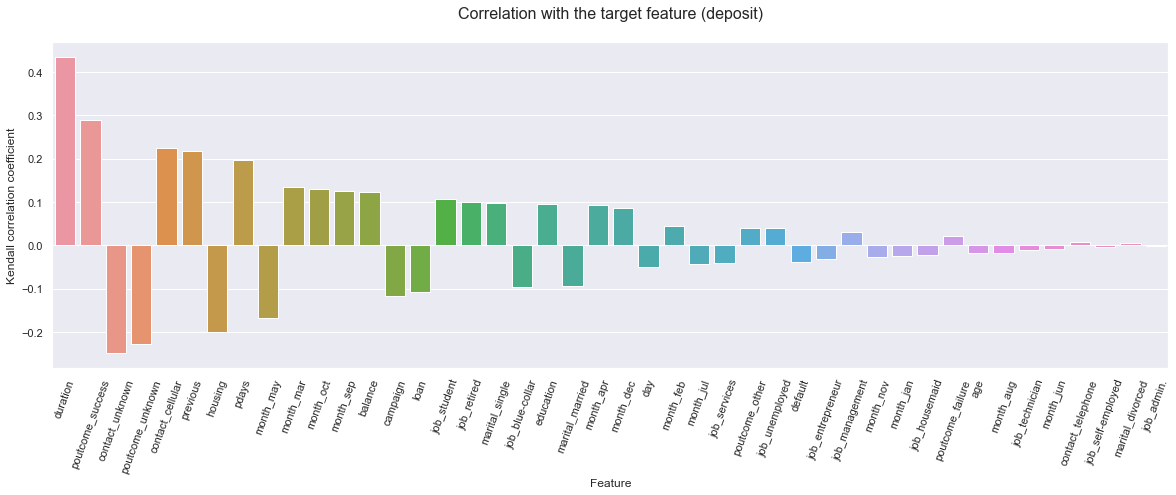

In [126]:
# Корреляция с целевым признаком

fig = plt.figure(figsize=(20,6))
plot_df = corr_matrix.drop('deposit')  # Убираем корреляцию "сам с собой"
feature_order = abs(plot_df['deposit']).sort_values(ascending=False).index
ax = sns.barplot(
    data=plot_df.reset_index(), x='index', y='deposit',
    order = feature_order)
plt.xticks(rotation=70)
ax.set(xlabel='Feature', ylabel='Kendall correlation coefficient')
ax.set_title('Correlation with the target feature (deposit)\n', fontsize=16);

### Задания 5 и 6

In [127]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [128]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 44)

In [129]:
round(y_test.mean(),2)

0.46

### Задание 7

In [130]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selected_cols = selector.get_feature_names_out()
print(f'Selected features:\n {selected_cols}')
X_train = selector.transform(X_train)
X_test =selector.transform(X_test)


Selected features:
 ['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 8

In [131]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [132]:
round(X_test[:,0].mean(),3)

812.863

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [133]:
# обучите логистическую регрессию и рассчитайте метрики качества
model_l = linear_model.LogisticRegression(solver = 'sag',random_state=42, max_iter= 1000)
model_l.fit(X_train_scaled,y_train)
y_train_pred = model_l.predict(X_train_scaled)
y_test_pred = model_l.predict(X_test_scaled)

In [134]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.81      0.82      0.81      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2,3,4

In [135]:
# обучите решающие деревья, настройте максимальную глубину
dtree = tree.DecisionTreeClassifier(max_depth=6,criterion='entropy', random_state=42)
dtree.fit(X_train, y_train)
y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))

Обучающая выборка:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задание 5

In [136]:
from sklearn.model_selection import GridSearchCV

In [137]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {'min_samples_leaf': (2,5,7,10),
              'max_depth': (3, 5, 7),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid = param_grid , 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 203 ms
Wall time: 3.12 s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [138]:
# обучите на ваших данных случайный лес
model_rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42)
model_rf.fit(X_train_scaled,y_train)
y_train_pred = model_rf.predict(X_train_scaled)
y_test_pred = model_rf.predict(X_test_scaled)


In [139]:
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred,digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Обучающая выборка:
              precision    recall  f1-score   support

           0      0.872     0.848     0.859      3634
           1      0.829     0.855     0.842      3136

    accuracy                          0.851      6770
   macro avg      0.850     0.851     0.851      6770
weighted avg      0.852     0.851     0.851      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.887     0.760     0.819      1790
           1      0.761     0.888     0.820      1545

    accuracy                          0.819      3335
   macro avg      0.824     0.824     0.819      3335
weighted avg      0.829     0.819     0.819      3335



### Задания 2 и 3

In [140]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5,
    max_depth=5, random_state=42)
gboost.fit(X_train_scaled, y_train)

y_test_pred = gboost.predict(X_test_scaled)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.884     0.757     0.816      1790
           1      0.759     0.885     0.817      1545

    accuracy                          0.816      3335
   macro avg      0.821     0.821     0.816      3335
weighted avg      0.826     0.816     0.816      3335



### Задание 4

In [141]:
# объедините уже известные вам алгоритмы с помощью стекинга 
dtree = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=7, min_samples_split=7, random_state=42)
logregr = linear_model.LogisticRegression(
    solver='sag', max_iter=1000, random_state=42)
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)

estimators = [
    ('dtree', dtree), ('logregr', logregr), ('gboost', gboost)]

stacked = ensemble.StackingClassifier(estimators=estimators)
stacked.fit(X_train_scaled, y_train)

y_test_pred = stacked.predict(X_test_scaled)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.876     0.780     0.825      1790
           1      0.774     0.872     0.820      1545

    accuracy                          0.823      3335
   macro avg      0.825     0.826     0.823      3335
weighted avg      0.829     0.823     0.823      3335



### Задание 5

In [142]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)
gboost.fit(X_train_scaled, y_train)
sorted(list(zip(selected_cols, gboost.feature_importances_)), 
       key=lambda x: x[1], reverse=True)

[('duration', 0.5141398765213597),
 ('poutcome_success', 0.11898787547990076),
 ('contact_unknown', 0.07895700907187311),
 ('balance', 0.061923041131863324),
 ('pdays', 0.05540967515546255),
 ('housing', 0.05046434132523583),
 ('month_mar', 0.027025009834081123),
 ('month_oct', 0.019516071222870888),
 ('campaign', 0.01800756251961814),
 ('month_sep', 0.015612600809316712),
 ('month_may', 0.014682145372349598),
 ('loan', 0.01271404314700361),
 ('previous', 0.007627283675145593),
 ('poutcome_unknown', 0.002944805803233918),
 ('contact_cellular', 0.001988658930685031)]

### Задания 6,7,8

In [143]:
import optuna
from sklearn.model_selection import cross_val_score 

In [144]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
    
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = cross_val_score(
        model, X_train_scaled, y_train, cv=5, scoring='f1').mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='RF_Classifier', direction='maximize')
study.optimize(obj_func, n_trials=10)
print(f'Лучшие параметры:\n{study.best_params}')

[I 2023-02-20 15:09:15,742] A new study created in memory with name: RF_Classifier
[I 2023-02-20 15:09:19,007] Trial 0 finished with value: 0.8194384044046383 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8194384044046383.
[I 2023-02-20 15:09:23,038] Trial 1 finished with value: 0.8230739833960005 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8230739833960005.
[I 2023-02-20 15:09:25,617] Trial 2 finished with value: 0.8178520153816178 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8230739833960005.
[I 2023-02-20 15:09:29,242] Trial 3 finished with value: 0.8166311996288224 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8230739833960005.
[I 2023-02-20 15:09:34,098] Trial 4 finished with value: 0.8219568870577019 and parameters: {'n_estimato

Лучшие параметры:
{'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}


In [145]:
# Модель с лучшими параметрами  
rf_best = ensemble.RandomForestClassifier(
    **study.best_params, random_state=42)
rf_best.fit(X_train, y_train)
y_test_pred = rf_best.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.850     0.819     0.834      1790
           1      0.799     0.833     0.816      1545

    accuracy                          0.825      3335
   macro avg      0.825     0.826     0.825      3335
weighted avg      0.827     0.825     0.826      3335



In [146]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [147]:
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]

sqrt(mean_squared_error(y_true,y_pred))


5.746042116100439

## Общий вывод ##

- Проведена предобработка признаков. Простыми способами (медиана, мода) заменены пропущенные значения. Методом Тьюкки удалены выбросы баланса.
- Проведен разведывательный анализ данных в контексте влияния на целевой признак.
- Проведено кодирование признаков и масштабирование значений. Для соответствия ответам на обучающей платформе не соблюдается порядковое кодирование возрастных групп - фактически они маркируются как несвязанные зависимостью классы (Label Encoder). Не проводилась трансформация признаков к нормальному распределению.
- На основе корреляции Кендалла дана оценка влияния признаков на целевой признак (выбрана из-за очевидного отсутствия связи с целевым признаком по монотонной функции, а также ввиду распределений признаков, отличных от нормальных). С помощью ANOVA F-value (f_classif) для построения моделей отобраны 15 наиболее значимых признаков, отобор в целом соответствует результатам по корреляции Кендалла. Попытка отобрать признаки по взаимной информации (mutual_info_classif, не отображено в данном ноутбуке) показала большое несоответствие с оценкой значимости по корреляции Кендалла.
- Построены простые базовые модели - логистическая регрессия и решающее дерево.
- Построены ансамблевые модели - случайный лес, градиентный бустинг на решающих деревьх, стекинг из деревьев, регрессии и бустинга.
-Реализованы примеры подбора гиперпараметров - поиск по сетке, Tree-tructured Parzen estimator (в Optuna).
- На каждом этапе моделирования оценивались метрики качества классификации. Ансамблевые решения закономерно показывают лучшие значения. Какая либо качественная разница между ансамблевыми моделями на данном датасете не прослеживается. Подбор гиперпараметров модели случайного леса незначительно, на десятые доли процента, улучшил результат.


Задача решена на базовом уровне в соответствии с минимумом требований, необходимых для сдачи проекта. Безусловно остается потенциал по возможному улучшению метрик при более тщательной и творческой обработке признаков, транформации данных, экспериментировании с различными моделями.